In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=[
      tfds.Split.TRAIN.subsplit(tfds.percent[:80]),
      tfds.Split.TRAIN.subsplit(tfds.percent[80:90]),
      tfds.Split.TRAIN.subsplit(tfds.percent[90:])
    ],
    with_info=True,
    as_supervised=True,
)

In [4]:
metadata.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=5)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
%config inlineBackend.figure_format = 'retina'

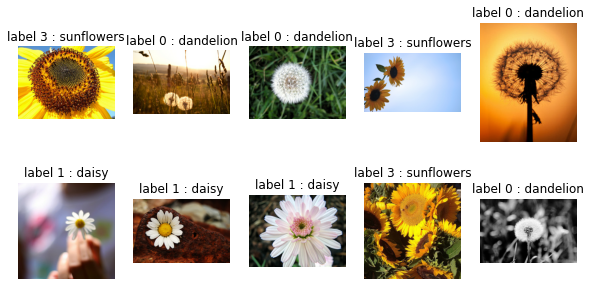

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title("label {} : {}".format(label, get_label_name(label)))
    plt.axis('off')

In [8]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

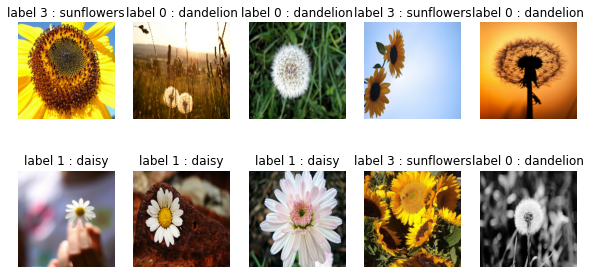

In [10]:
plt.figure(figsize = (10, 5))

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    plt.title("label {} : {}".format(label, get_label_name(label)))
    plt.axis('off')

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [12]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=5, activation = 'softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

In [14]:
base_learning_rate = 0.0001

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss = tf.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [18]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
93/93 [==============================] - 20s 214ms/step - loss: 1.3271 - accuracy: 0.4424 - val_loss: 1.1510 - val_accuracy: 0.5361
Epoch 2/10
93/93 [==============================] - 3s 29ms/step - loss: 1.0576 - accuracy: 0.5739 - val_loss: 1.0847 - val_accuracy: 0.5278
Epoch 3/10
93/93 [==============================] - 3s 28ms/step - loss: 0.9356 - accuracy: 0.6363 - val_loss: 1.2042 - val_accuracy: 0.5028
Epoch 4/10
93/93 [==============================] - 3s 28ms/step - loss: 0.8265 - accuracy: 0.6875 - val_loss: 0.9472 - val_accuracy: 0.6139
Epoch 5/10
93/93 [==============================] - 3s 29ms/step - loss: 0.7296 - accuracy: 0.7308 - val_loss: 1.0079 - val_accuracy: 0.5833
Epoch 6/10
93/93 [==============================] - 3s 29ms/step - loss: 0.6337 - accuracy: 0.7712 - val_loss: 1.0222 - val_accuracy: 0.6167
Epoch 7/10
93/93 [==============================] - 3s 28ms/step - loss: 0.5476 - accuracy: 0.8064 - val_loss: 0.9563 - val_accuracy: 0.6306
Epoch 8/10


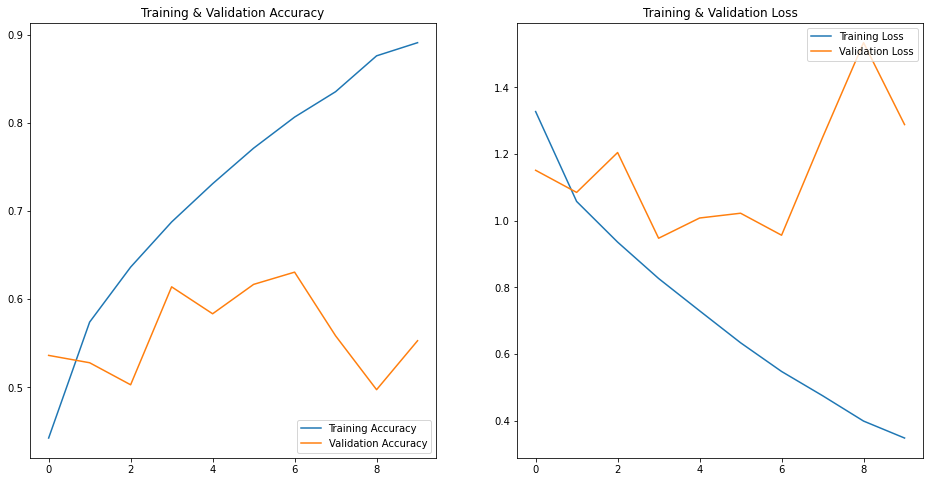

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training & Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training & Validation Loss")
plt.show()

In [21]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[6.63788337e-03, 6.15432978e-01, 1.06348582e-02, 9.74677459e-05,
        3.67196828e-01],
       [1.09889917e-03, 3.04553076e-03, 8.67157127e-04, 9.89373505e-01,
        5.61503973e-03],
       [1.61325559e-02, 9.24826801e-01, 7.88214710e-03, 9.86324158e-05,
        5.10599539e-02],
       [2.73623280e-02, 1.32593647e-01, 2.08569244e-02, 5.08219041e-02,
        7.68365145e-01],
       [9.87254977e-01, 1.11364117e-02, 4.68582817e-04, 3.11123586e-06,
        1.13693101e-03],
       [4.38852876e-04, 2.21281406e-03, 7.22304955e-02, 1.11732843e-05,
        9.25106645e-01],
       [7.42027089e-02, 4.13594127e-01, 1.21113345e-01, 5.70197310e-03,
        3.85387868e-01],
       [9.41034853e-02, 6.84594631e-01, 1.26284184e-02, 2.84577691e-04,
        2.08388835e-01],
       [2.62409518e-03, 6.09156713e-02, 3.81806493e-02, 8.61699820e-01,
        3.65797728e-02],
       [1.35508412e-03, 2.02412927e-03, 4.18122202e-01, 6.38830708e-04,
        5.77859759e-01],
       [8.07595611e-01, 4.7538

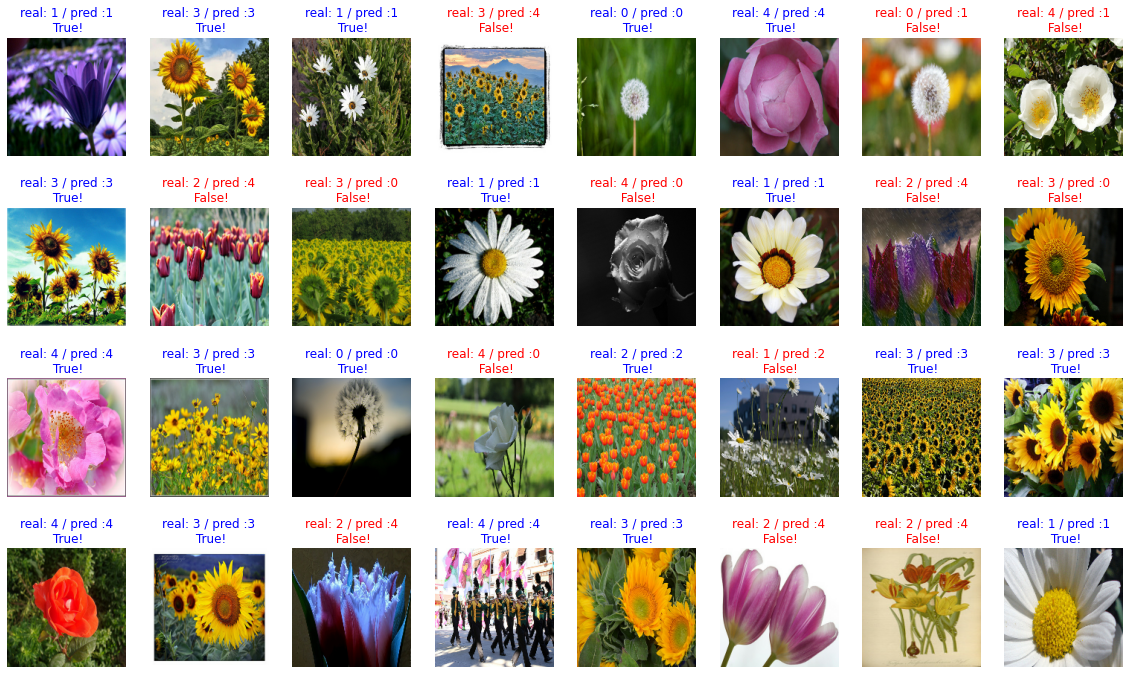

In [22]:
import numpy as np

predictions = np.argmax(predictions, axis=1)

plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [23]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
  correct = label == prediction
  if correct:
    count = count + 1

print(count / 32 * 100)    # 약 70% 내외

59.375


In [24]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(
    input_shape = IMG_SHAPE,
    include_top = False,
    weights = 'imagenet')

In [25]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [26]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [27]:
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [28]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [29]:
dense_layer = Dense(512, activation = 'relu')
prediction_layer = Dense(5, activation = 'softmax')

In [30]:
base_model.trainable = False

In [31]:
model = Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 2565      
Total params: 14,979,909
Trainable params: 265,221
Non-trainable params: 14,714,688
_________________________________________________________________


In [33]:
base_learning_rate = 0.0001

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr = base_learning_rate),
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [34]:
EPOCHS = 5

history = model.fit(train_batches,
                   epochs = EPOCHS,
                   validation_data = validation_batches)

Epoch 1/5
93/93 [==============================] - 51s 551ms/step - loss: 1.3631 - accuracy: 0.5149 - val_loss: 1.1406 - val_accuracy: 0.6833
Epoch 2/5
93/93 [==============================] - 7s 76ms/step - loss: 1.0375 - accuracy: 0.6905 - val_loss: 0.9109 - val_accuracy: 0.7389
Epoch 3/5
93/93 [==============================] - 7s 76ms/step - loss: 0.8612 - accuracy: 0.7441 - val_loss: 0.7751 - val_accuracy: 0.7472
Epoch 4/5
93/93 [==============================] - 7s 76ms/step - loss: 0.7599 - accuracy: 0.7685 - val_loss: 0.7162 - val_accuracy: 0.7694
Epoch 5/5
93/93 [==============================] - 7s 77ms/step - loss: 0.6923 - accuracy: 0.7868 - val_loss: 0.6469 - val_accuracy: 0.7833


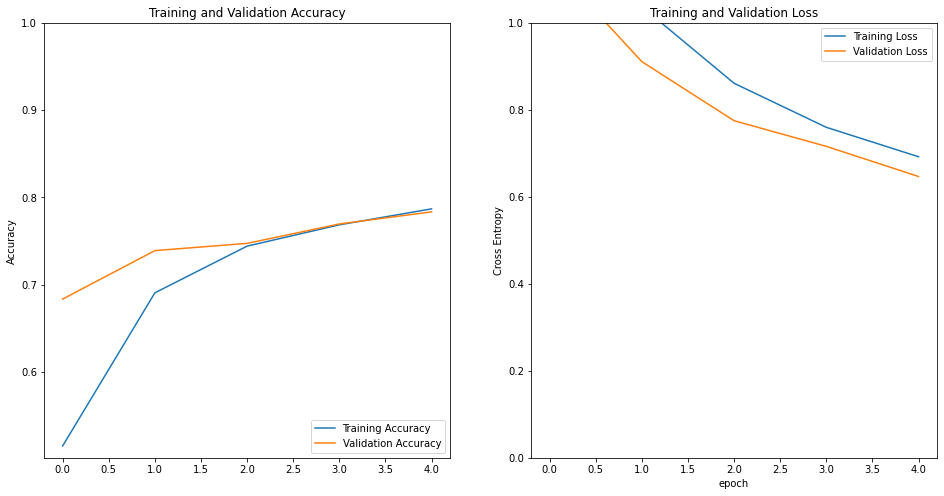

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[8.40160325e-02, 4.59005028e-01, 3.27403009e-01, 8.87656584e-02,
        4.08103280e-02],
       [1.32521605e-02, 1.39704019e-01, 1.22969290e-02, 8.09476733e-01,
        2.52702199e-02],
       [1.95715517e-01, 4.19475913e-01, 8.75489339e-02, 2.61980027e-01,
        3.52795310e-02],
       [8.21003225e-03, 4.59577106e-02, 1.78716287e-01, 5.48818409e-01,
        2.18297511e-01],
       [6.16645396e-01, 2.24687427e-01, 7.50971660e-02, 5.94210438e-02,
        2.41490025e-02],
       [1.87629461e-03, 1.52246580e-02, 2.61062652e-01, 6.11054990e-03,
        7.15725899e-01],
       [9.32881117e-01, 3.24549526e-02, 9.04042646e-03, 2.00361479e-02,
        5.58729749e-03],
       [2.97315810e-02, 8.17439929e-02, 1.45287424e-01, 5.39708674e-01,
        2.03528315e-01],
       [6.39881194e-02, 3.37337971e-01, 7.59885982e-02, 4.56228077e-01,
        6.64572567e-02],
       [3.67411459e-03, 6.49328576e-03, 9.74240124e-01, 7.70305935e-03,
        7.88934715e-03],
       [1.28236860e-01, 5.5622

In [37]:
predictions = np.argmax(predictions, axis=1)
predictions

array([1, 3, 1, 3, 0, 4, 0, 3, 3, 2, 3, 1, 4, 1, 0, 3, 4, 2, 0, 4, 2, 2,
       3, 3, 4, 3, 2, 2, 3, 2, 4, 1])

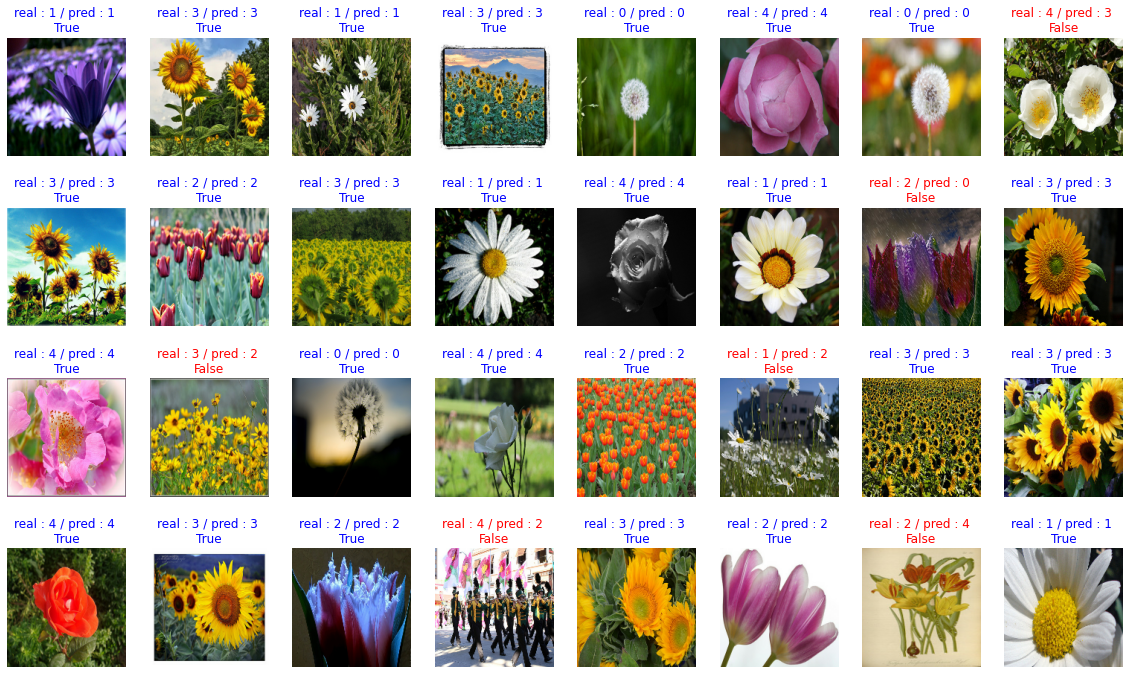

In [38]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    correct = label == prediction
    title = "real : {} / pred : {} \n{}".format(label, prediction, correct)
    if not correct:
        plt.title(title, fontdict={'color' : 'red'})
    else:
        plt.title(title, fontdict={'color' : 'blue'})
    plt.axis('off')
